# MNIST Digit Classification (COM7019) – Sigmoid vs Tanh

Dataset is loaded from local `.npy` files in the same folder:
`train_images.npy`, `train_labels.npy`, `test_images.npy`, `test_labels.npy`.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import time

# Reproducibility
np.random.seed(42)


## 1) Load the dataset (.npy)


In [2]:
# Load the numpy files (keep them in the same folder as this notebook)
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images  = np.load('test_images.npy')
test_labels  = np.load('test_labels.npy')

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape:     {test_images.shape}")
print(f"Test labels shape:     {test_labels.shape}")


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape:     (10000, 28, 28)
Test labels shape:     (10000,)


## 2) Visualise a few samples


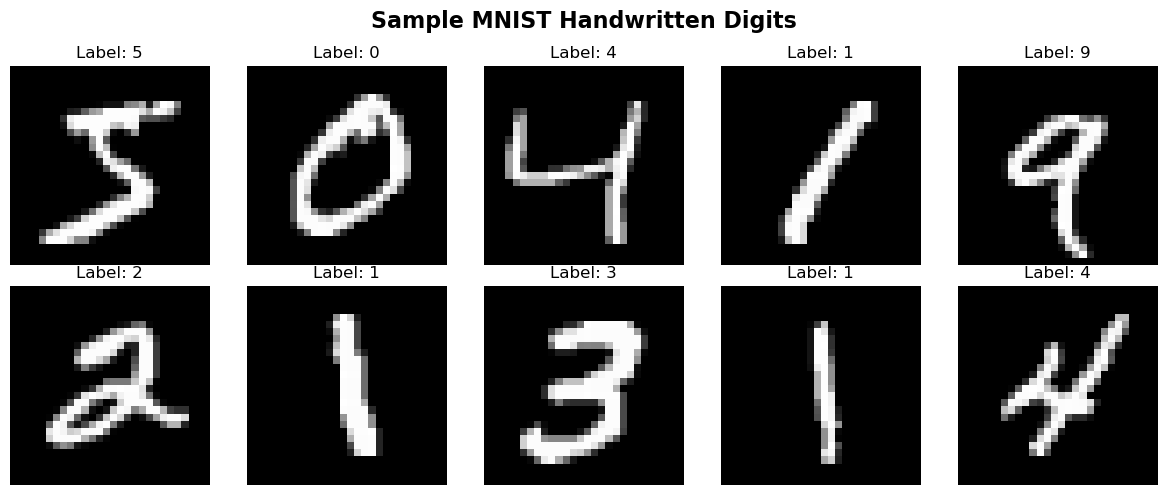

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].set_title(f'Label: {train_labels[i]}', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Sample MNIST Handwritten Digits', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 3) Preprocessing

- Flatten 28×28 images to 784 features
- Normalise pixel values to `[0, 1]`
- One-hot encode labels
- Create a validation split from the training set


In [4]:
# Flatten and normalise
X_train = train_images.reshape(train_images.shape[0], -1).astype(np.float32) / 255.0
X_test  = test_images.reshape(test_images.shape[0], -1).astype(np.float32) / 255.0

# One-hot encode labels
def one_hot(labels, num_classes=10):
    out = np.zeros((labels.shape[0], num_classes), dtype=np.float32)
    out[np.arange(labels.shape[0]), labels.astype(int)] = 1.0
    return out

y_train_oh = one_hot(train_labels, 10)
y_test_oh  = one_hot(test_labels, 10)

# Validation split (10%)
val_fraction = 0.1
n = X_train.shape[0]
indices = np.random.permutation(n)

val_size = int(n * val_fraction)
val_idx = indices[:val_size]
trn_idx = indices[val_size:]

X_val, y_val, y_val_raw = X_train[val_idx], y_train_oh[val_idx], train_labels[val_idx]
X_trn, y_trn, y_trn_raw = X_train[trn_idx], y_train_oh[trn_idx], train_labels[trn_idx]

print("Train split:", X_trn.shape, y_trn.shape)
print("Val split:  ", X_val.shape, y_val.shape)
print("Test:       ", X_test.shape, y_test_oh.shape)


Train split: (54000, 784) (54000, 10)
Val split:   (6000, 784) (6000, 10)
Test:        (10000, 784) (10000, 10)


## 4) Activation functions


In [5]:
def sigmoid_activation(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_derivative(a):
    # derivative using activation output
    return a * (1.0 - a)

def tanh_activation(z):
    return np.tanh(z)

def tanh_derivative(a):
    return 1.0 - (a ** 2)

def softmax_activation(z):
    z = z - np.max(z, axis=1, keepdims=True)  # stability
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)


## 5) Digit classifier


In [14]:
class DigitClassifier:
    # Neural network for digit classification (6 hidden layers)

    def __init__(self, layer_sizes, activation_type='sigmoid', learning_rate=0.001):
        self.layers = layer_sizes
        self.activation_type = activation_type
        self.lr = learning_rate

        # Choose activation function
        if activation_type == 'sigmoid':
            self.activate = sigmoid_activation
            self.activate_deriv = sigmoid_derivative
        else:  # tanh
            self.activate = tanh_activation
            self.activate_deriv = tanh_derivative

        # Xavier/Glorot initialization (good baseline for sigmoid/tanh)
        self.weights = []
        self.biases = []

        for i in range(len(layer_sizes) - 1):
            fan_in, fan_out = layer_sizes[i], layer_sizes[i+1]
            limit = np.sqrt(6.0 / (fan_in + fan_out))
            w = np.random.uniform(-limit, limit, (fan_in, fan_out)).astype(np.float32)
            b = np.zeros((1, fan_out), dtype=np.float32)
            self.weights.append(w)
            self.biases.append(b)

        # Adam optimiser state
        self.m_w = [np.zeros_like(w) for w in self.weights]
        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.v_b = [np.zeros_like(b) for b in self.biases]
        self.t = 0

        # Track training history
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }

    def forward_pass(self, X):
        """Pass data through the network"""
        layer_outputs = [X]

        # Hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(layer_outputs[-1], self.weights[i]) + self.biases[i]
            a = self.activate(z)
            layer_outputs.append(a)

        # Output layer with softmax
        z_out = np.dot(layer_outputs[-1], self.weights[-1]) + self.biases[-1]
        a_out = softmax_activation(z_out)
        layer_outputs.append(a_out)

        return layer_outputs

    def backward_pass(self, X, y, layer_outputs):
        """Calculate gradients using backpropagation"""
        m = X.shape[0]
        weight_grads = []
        bias_grads = []

        # Output error (softmax + cross entropy)
        delta = layer_outputs[-1] - y

        # Backprop through layers
        for i in range(len(self.weights) - 1, -1, -1):
            dW = np.dot(layer_outputs[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m

            weight_grads.insert(0, dW)
            bias_grads.insert(0, db)

            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activate_deriv(layer_outputs[i])

        return weight_grads, bias_grads

    def update_weights_adam(self, weight_grads, bias_grads, beta1=0.9, beta2=0.999, eps=1e-8):
        """Update parameters using Adam"""
        self.t += 1

        for i in range(len(self.weights)):
            # Weights
            self.m_w[i] = beta1 * self.m_w[i] + (1 - beta1) * weight_grads[i]
            self.v_w[i] = beta2 * self.v_w[i] + (1 - beta2) * (weight_grads[i] ** 2)

            m_hat = self.m_w[i] / (1 - beta1 ** self.t)
            v_hat = self.v_w[i] / (1 - beta2 ** self.t)

            self.weights[i] -= self.lr * m_hat / (np.sqrt(v_hat) + eps)

            # Biases
            self.m_b[i] = beta1 * self.m_b[i] + (1 - beta1) * bias_grads[i]
            self.v_b[i] = beta2 * self.v_b[i] + (1 - beta2) * (bias_grads[i] ** 2)

            mb_hat = self.m_b[i] / (1 - beta1 ** self.t)
            vb_hat = self.v_b[i] / (1 - beta2 ** self.t)

            self.biases[i] -= self.lr * mb_hat / (np.sqrt(vb_hat) + eps)

    def calculate_loss(self, y_true, y_pred):
        """Cross-entropy loss"""
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def calculate_accuracy(self, y_true, y_pred):
        """Calculate prediction accuracy"""
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)

    def train_network(self, X_train, y_train, X_val, y_val, epochs=30, batch_size=128):
        """Train the network"""
        n_samples = X_train.shape[0]
        n_batches = n_samples // batch_size

        print(f"\nTraining with {self.activation_type.upper()} activation")
        print(f"Architecture: {' -> '.join(map(str, self.layers))}")
        print(f"Optimiser: Adam | Learning rate: {self.lr}")
        print("-" * 70)

        start_time = time.time()

        for epoch in range(epochs):
            # Shuffle data each epoch
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Train on batches
            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                outputs = self.forward_pass(X_batch)
                w_grads, b_grads = self.backward_pass(X_batch, y_batch, outputs)
                self.update_weights_adam(w_grads, b_grads)

            # Metrics each epoch
            train_pred = self.forward_pass(X_train)[-1]
            val_pred   = self.forward_pass(X_val)[-1]

            train_loss = self.calculate_loss(y_train, train_pred)
            val_loss   = self.calculate_loss(y_val, val_pred)
            train_acc  = self.calculate_accuracy(y_train, train_pred)
            val_acc    = self.calculate_accuracy(y_val, val_pred)

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)

            # Print progress every 5 epochs (like the reference)
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1:3d}/{epochs} - "
                      f"Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - "
                      f"Val_Loss: {val_loss:.4f} - Val_Acc: {val_acc:.4f}")

        train_time = time.time() - start_time
        print(f"\nTraining completed in {train_time:.2f} seconds")
        print(f"Final validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")

        return train_time

    def predict(self, X):
        """Return predicted probabilities"""
        return self.forward_pass(X)[-1]


## 6) Network structure (6 hidden layers)


In [7]:
# Network structure: Input -> 6 hidden layers -> Output
network_structure = [
    784,   # Input (28x28 flattened)
    256,   # Hidden layer 1
    128,   # Hidden layer 2
    128,   # Hidden layer 3
    64,    # Hidden layer 4
    64,    # Hidden layer 5
    32,    # Hidden layer 6
    10     # Output layer (10 classes)
]

print("Network structure:", " -> ".join(map(str, network_structure)))


Network structure: 784 -> 256 -> 128 -> 128 -> 64 -> 64 -> 32 -> 10


## 7) Train and compare: Sigmoid vs Tanh (lr=0.001 for both)


In [8]:
EPOCHS = 30
BATCH_SIZE = 128
LR = 0.001

# Train Sigmoid model
sigmoid_model = DigitClassifier(network_structure, activation_type='sigmoid', learning_rate=LR)
sigmoid_time = sigmoid_model.train_network(X_trn, y_trn, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Train Tanh model
tanh_model = DigitClassifier(network_structure, activation_type='tanh', learning_rate=LR)
tanh_time = tanh_model.train_network(X_trn, y_trn, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE)

print(f"\nTraining times (seconds): Sigmoid={sigmoid_time:.2f}, Tanh={tanh_time:.2f}")



Training with SIGMOID activation
Architecture: 784 -> 256 -> 128 -> 128 -> 64 -> 64 -> 32 -> 10
Optimiser: Adam | Learning rate: 0.001
----------------------------------------------------------------------
Epoch   5/30 - Loss: 0.2334 - Acc: 0.9463 - Val_Loss: 0.2630 - Val_Acc: 0.9397
Epoch  10/30 - Loss: 0.1144 - Acc: 0.9736 - Val_Loss: 0.1868 - Val_Acc: 0.9548
Epoch  15/30 - Loss: 0.0619 - Acc: 0.9861 - Val_Loss: 0.1476 - Val_Acc: 0.9657
Epoch  20/30 - Loss: 0.0461 - Acc: 0.9890 - Val_Loss: 0.1420 - Val_Acc: 0.9673
Epoch  25/30 - Loss: 0.0287 - Acc: 0.9935 - Val_Loss: 0.1366 - Val_Acc: 0.9705
Epoch  30/30 - Loss: 0.0190 - Acc: 0.9960 - Val_Loss: 0.1183 - Val_Acc: 0.9747

Training completed in 84.75 seconds
Final validation accuracy: 0.9747 (97.47%)

Training with TANH activation
Architecture: 784 -> 256 -> 128 -> 128 -> 64 -> 64 -> 32 -> 10
Optimiser: Adam | Learning rate: 0.001
----------------------------------------------------------------------
Epoch   5/30 - Loss: 0.0423 - Acc: 

## 8) Learning curves


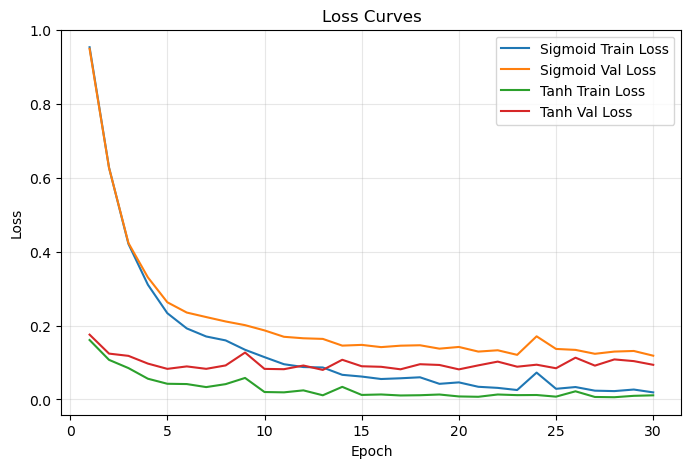

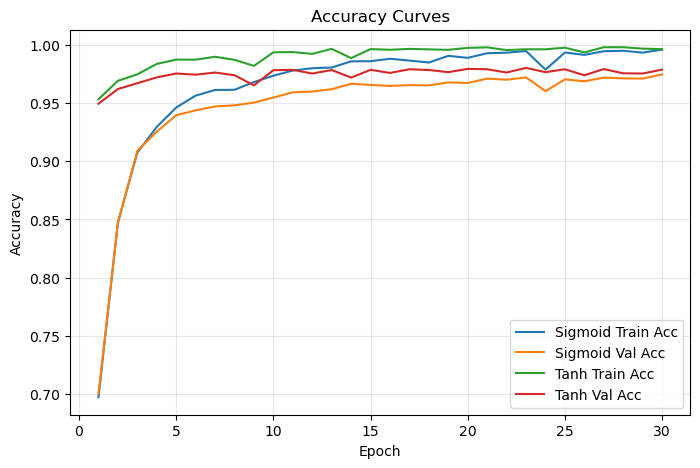

In [9]:
def plot_learning_curves(model_a, model_b, label_a='Sigmoid', label_b='Tanh'):
    epochs = range(1, len(model_a.history['train_loss']) + 1)

    # Loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, model_a.history['train_loss'], label=f'{label_a} Train Loss')
    plt.plot(epochs, model_a.history['val_loss'], label=f'{label_a} Val Loss')
    plt.plot(epochs, model_b.history['train_loss'], label=f'{label_b} Train Loss')
    plt.plot(epochs, model_b.history['val_loss'], label=f'{label_b} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, model_a.history['train_acc'], label=f'{label_a} Train Acc')
    plt.plot(epochs, model_a.history['val_acc'], label=f'{label_a} Val Acc')
    plt.plot(epochs, model_b.history['train_acc'], label=f'{label_b} Train Acc')
    plt.plot(epochs, model_b.history['val_acc'], label=f'{label_b} Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curves(sigmoid_model, tanh_model)


## 9) Test set evaluation + confusion matrices


Sigmoid (Adam lr=0.001) | Test Loss: 0.1390 | Test Accuracy: 97.17%


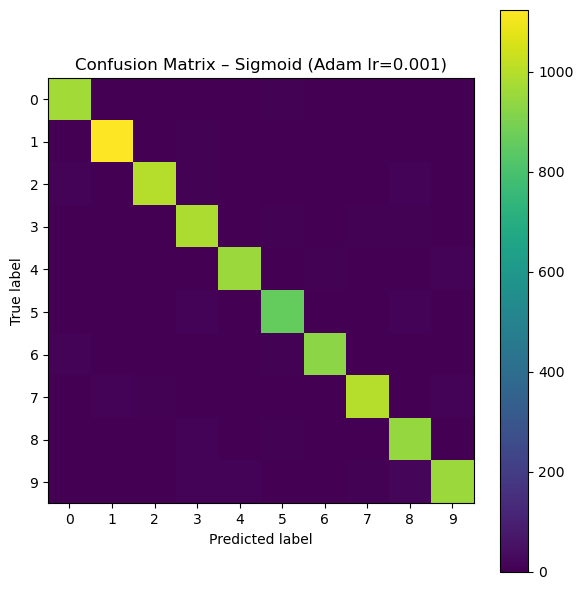

Tanh (Adam lr=0.001) | Test Loss: 0.1238 | Test Accuracy: 97.31%


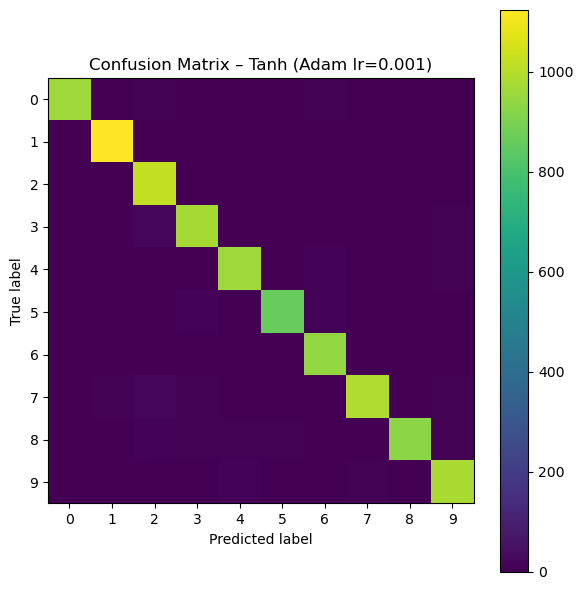

In [10]:
def evaluate_and_confusion(model, X, y_true_raw, y_true_oh, title):
    probs = model.predict(X)
    preds = np.argmax(probs, axis=1)

    # Loss and accuracy
    loss = -np.sum(y_true_oh * np.log(probs + 1e-8)) / y_true_oh.shape[0]
    acc = np.mean(preds == y_true_raw)

    print(f"{title} | Test Loss: {loss:.4f} | Test Accuracy: {acc*100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(y_true_raw, preds)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix – {title}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.tight_layout()
    plt.show()

    return preds, probs, cm

sig_preds, sig_probs, sig_cm = evaluate_and_confusion(sigmoid_model, X_test, test_labels, y_test_oh, "Sigmoid (Adam lr=0.001)")
tanh_preds, tanh_probs, tanh_cm = evaluate_and_confusion(tanh_model, X_test, test_labels, y_test_oh, "Tanh (Adam lr=0.001)")


## 10) Classification report


In [11]:
print("Sigmoid report:")
print(classification_report(test_labels, sig_preds, digits=4))

print("\nTanh report:")
print(classification_report(test_labels, tanh_preds, digits=4))


Sigmoid report:
              precision    recall  f1-score   support

           0     0.9700    0.9888    0.9793       980
           1     0.9791    0.9894    0.9842      1135
           2     0.9813    0.9661    0.9736      1032
           3     0.9545    0.9772    0.9658      1010
           4     0.9815    0.9725    0.9770       982
           5     0.9695    0.9630    0.9663       892
           6     0.9872    0.9697    0.9784       958
           7     0.9765    0.9698    0.9732      1028
           8     0.9488    0.9713    0.9599       974
           9     0.9686    0.9465    0.9574      1009

    accuracy                         0.9717     10000
   macro avg     0.9717    0.9714    0.9715     10000
weighted avg     0.9718    0.9717    0.9717     10000


Tanh report:
              precision    recall  f1-score   support

           0     0.9886    0.9776    0.9831       980
           1     0.9894    0.9894    0.9894      1135
           2     0.9444    0.9874    0.9654     

## 11) A few example predictions

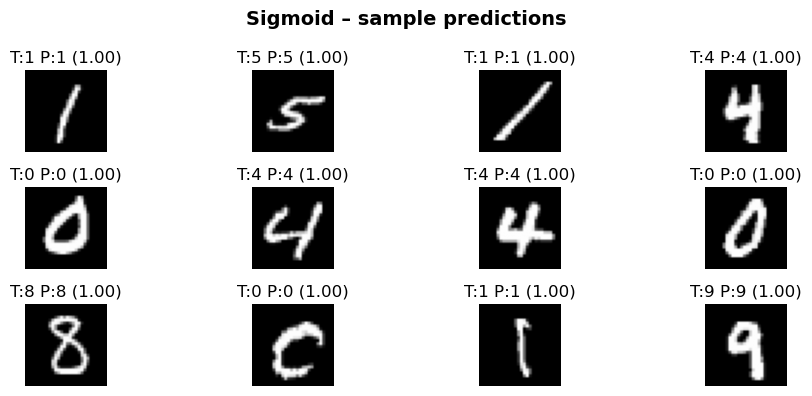

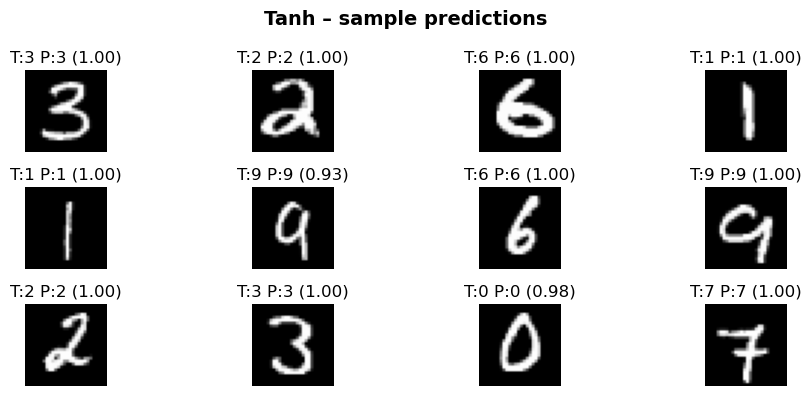

In [12]:
def show_examples(images, true_labels, probs, title, n=12):
    idx = np.random.choice(len(true_labels), size=n, replace=False)
    plt.figure(figsize=(10, 4))
    for i, j in enumerate(idx, start=1):
        plt.subplot(3, 4, i)
        plt.imshow(images[j], cmap='gray')
        pred = np.argmax(probs[j])
        conf = np.max(probs[j])
        plt.title(f"T:{true_labels[j]} P:{pred} ({conf:.2f})")
        plt.axis('off')
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_examples(test_images, test_labels, sig_probs, "Sigmoid – sample predictions")
show_examples(test_images, test_labels, tanh_probs, "Tanh – sample predictions")
